In [1]:
from typing import Any

import matplotlib.pyplot as plt
import mlflow
import mlflow.artifacts
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from mlflow.store.entities.paged_list import PagedList
from mlflow.tracking import MlflowClient

from cate.infra.mlflow import REMOTE_TRACKING_URI


In [2]:
experiment_name = "base_pattern"

In [3]:
mlflow.set_tracking_uri(REMOTE_TRACKING_URI)
client = MlflowClient(tracking_uri=REMOTE_TRACKING_URI)

In [4]:
experiment = client.search_experiments(filter_string=f"name='{experiment_name}'")[0]

In [5]:
def get_child_runs(parent_run_id) -> PagedList:
    return client.search_runs(
        experiment.experiment_id,
        filter_string=f"tags.mlflow.parentRunId='{parent_run_id}'",
    )

In [6]:
def parse_run(run) -> dict[str, Any]:
    _metrics = run.to_dictionary()["data"]["metrics"]
    _tags = run.to_dictionary()["data"]["tags"]
    metrics_keys = [
        "auuc",
        "uplift_at_10",
        "uplift_at_20",
        "uplift_at_30",
        "uplift_at_40",
        "uplift_at_50",
        "uplift_at_60",
        "uplift_at_70",
        "uplift_at_80",
        "uplift_at_90",
    ]
    tags_keys = ["model", "dataset"]
    return {
        **{k: _metrics[k] for k in metrics_keys},
        **{k: _tags[k] for k in tags_keys},
    }

In [ ]:
def get_metric_history(run_id: str, metric: str) -> npt.NDArray:
    history = client.get_metric_history(run_id, metric)
    return np.array([h.value for h in history])


In [7]:
dataset_names = ("criteo", "lenta", "megafon", "hillstorm")
parent_run_ids = [
    "2c3b94270d904d659f34386dae502909",
    "d15e430478a54a23b1a04408591a9b06",
    "f5804c7e54654b15900de2f36cebe6eb",
    "e98550a7145f4f6bbf3739757afa3c89",
]

In [19]:
df = None
for dataset_name, parent_run_id in zip(dataset_names, parent_run_ids):
    runs = get_child_runs(parent_run_id)
    data = [parse_run(run) for run in runs]
    _df = pd.DataFrame(data)
    if df is None:
        df = _df
    else:
        df = pd.concat([df, _df])
df = df.reset_index(drop=True)

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder_model = LabelEncoder()
label_encoder_dataset = LabelEncoder()

encoded_df = df.copy()
encoded_df['model'] = label_encoder_model.fit_transform(df['model'])
encoded_df["dataset"] = label_encoder_dataset.fit_transform(df["dataset"])

In [21]:
corr = encoded_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [22]:
df

auuc  uplift_at_10  uplift_at_20  uplift_at_30  uplift_at_40  \
0   0.045739      0.007262      0.004338      0.003104      0.002393   
1   0.052503      0.008022      0.004808      0.003427      0.002638   
2   0.051526      0.007768      0.004565      0.003403      0.002602   
3   0.049980      0.007637      0.004623      0.003279      0.002573   
4   0.053790      0.008064      0.004831      0.003468      0.002669   
5   0.017894      0.007991      0.002796      0.003455      0.002827   
6   0.060887      0.009428      0.004884      0.003011      0.002262   
7   0.001479     -0.000168     -0.001074      0.001785      0.006098   
8   0.066990      0.008103      0.003685      0.005436      0.004872   
9   0.060862      0.006856      0.005927      0.005291      0.005113   
10  3.471237      0.448534      0.284832      0.219991      0.187750   
11  3.298296      0.414938      0.267715      0.211160      0.180544   
12  3.332212      0.433860      0.273752      0.211402      0.180117   
13  3.354283      0.436749      0.274463      0.215203      0.183828   
14  3.290144      0.419236      0.272687      0.214677      0.181830   
15  0.044402      0.008187      0.008571      0.003704      0.001204   
16  0.009471     -0.001593      0.000572      0.000810      0.002416   
17  0.029000      0.000871      0.005669      0.003243      0.003264   
18  0.021992      0.008519      0.001269      0.002048      0.000284   
19 -0.009266     -0.000356      0.004460      0.001303     -0.000221   

    uplift_at_50  uplift_at_60  uplift_at_70  uplift_at_80  uplift_at_90  \
0       0.001947      0.001643      0.001421      0.001248      0.001116   
1       0.002147      0.001804      0.001550      0.001364      0.001224   
2       0.002128      0.001792      0.001549      0.001377      0.001238   
3       0.002091      0.001756      0.001515      0.001338      0.001205   
4       0.002178      0.001842      0.001592      0.001411      0.001264   
5       0.002232      0.002684      0.003793      0.003975      0.004684   
6       0.005392      0.006188      0.006445      0.006244      0.006020   
7       0.004630      0.004457      0.005121      0.004992      0.005420   
8       0.005454      0.006118      0.006735      0.005803      0.005869   
9       0.005933      0.006617      0.005952      0.006022      0.006285   
10      0.165706      0.146390      0.127339      0.102879      0.082211   
11      0.160844      0.145737      0.126924      0.104056      0.082102   
12      0.161337      0.144494      0.127051      0.103757      0.080752   
13      0.162426      0.145414      0.127650      0.104270      0.081250   
14      0.159760      0.144431      0.127156      0.103414      0.079550   
15      0.001335      0.001547      0.000714      0.001319      0.001487   
16      0.002008      0.000188      0.000708      0.001543      0.001336   
17      0.001927      0.002326      0.002099      0.001600      0.001655   
18      0.000786      0.000428      0.001099      0.001140      0.002082   
19     -0.001014     -0.001264      0.000618      0.000668      0.001432   

        model    dataset  
0    tlearner     criteo  
1    slearner     criteo  
2    rlearner     criteo  
3    xlearner     criteo  
4   drlearner     criteo  
5    tlearner      lenta  
6    slearner      lenta  
7    rlearner      lenta  
8    xlearner      lenta  
9   drlearner      lenta  
10   tlearner    megafon  
11   slearner    megafon  
12   rlearner    megafon  
13   xlearner    megafon  
14  drlearner    megafon  
15   tlearner  hillstorm  
16   slearner  hillstorm  
17   rlearner  hillstorm  
18   xlearner  hillstorm  
19  drlearner  hillstorm

In [26]:
evaluation_index = "auuc"
data = df.loc[:, [evaluation_index, "model", "dataset"]].pivot_table(
    index="dataset", columns="model", values=evaluation_index
)

In [27]:
data

model      drlearner  rlearner  slearner  tlearner  xlearner
dataset                                                     
criteo      0.053790  0.051526  0.052503  0.045739  0.049980
hillstorm  -0.009266  0.029000  0.009471  0.044402  0.021992
lenta       0.060862  0.001479  0.060887  0.017894  0.066990
megafon     3.290144  3.332212  3.298296  3.471237  3.354283

In [24]:
row_means = data.mean(axis=1)
data = data.sub(row_means, axis=0)
data

model      drlearner  rlearner  slearner  tlearner  xlearner
dataset                                                     
criteo      0.003082  0.000818  0.001795 -0.004968 -0.000727
hillstorm  -0.028386  0.009880 -0.009649  0.025282  0.002872
lenta       0.019240 -0.040144  0.019265 -0.023728  0.025367
megafon    -0.059090 -0.017023 -0.050938  0.122003  0.005049

<Axes: xlabel='dataset'>

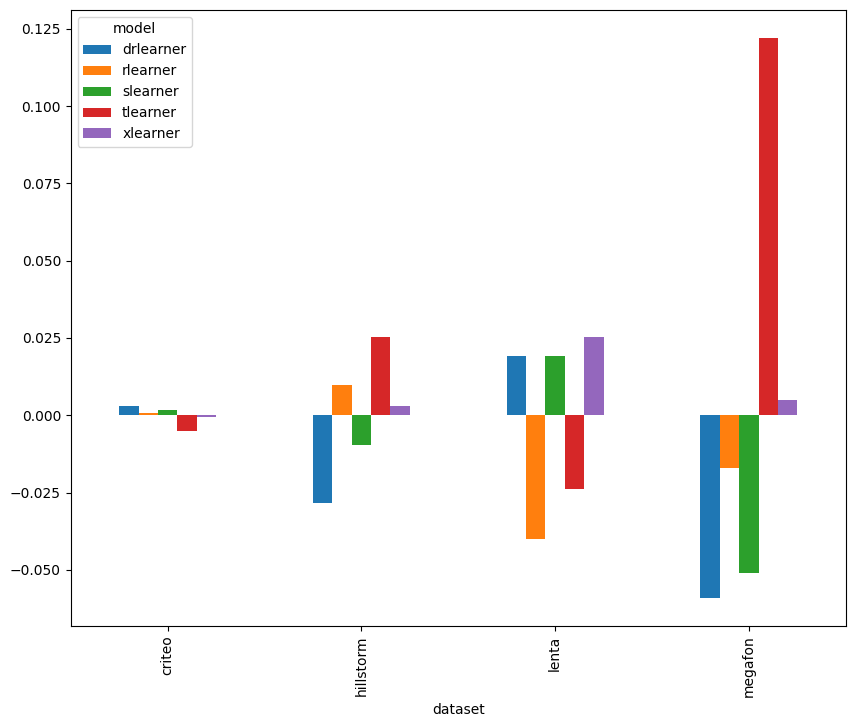

In [25]:
data.plot(kind="bar", stacked=False, figsize=(10, 8))